In [2]:
import torch
import torchvision

In [3]:
import scipy.io
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random
from matplotlib.pyplot import figure
import shutil
import os
import numpy as np

In [17]:
# load training annotations .mat file, convert to Pandas dataframe
mat = scipy.io.loadmat('data/citypersons_annotations/anno_train.mat')
full_data_arr=[]
for img_data in tqdm(mat['anno_train_aligned'][0]):
    for instance in img_data[0][0][2]:
        full_data_arr.append([img_data[0][0][0][0],img_data[0][0][1][0],instance[0],instance[1],instance[2],instance[3],instance[4],instance[5],instance[6],instance[7],instance[8],instance[9]])

train_df=pd.DataFrame(full_data_arr,columns=['city','image_id','class_label', 'x1','y1','w','h', 'instance_id', 'x1_vis', 'y1_vis', 'w_vis', 'h_vis'])


# load validation annotations .mat file, convert to Pandas dataframe
mat = scipy.io.loadmat('data/citypersons_annotations/anno_val.mat')
full_data_arr=[]
for img_data in tqdm(mat['anno_val_aligned'][0]):
    for instance in img_data[0][0][2]:
        full_data_arr.append([img_data[0][0][0][0],img_data[0][0][1][0],instance[0],instance[1],instance[2],instance[3],instance[4],instance[5],instance[6],instance[7],instance[8],instance[9]])

val_df=pd.DataFrame(full_data_arr,columns=['city','image_id','class_label', 'x1','y1','w','h', 'instance_id', 'x1_vis', 'y1_vis', 'w_vis', 'h_vis'])


# create the class labels
class_dict={0: 'ignore regions' ,
1: 'pedestrians',
2: 'riders',
3: 'sitting persons',
4: 'other persons unusual postures',
5: 'group of people'}

print(val_df['class_label'].value_counts())
print(train_df['class_label'].value_counts())

### checking if all the images are available
all_imgs=train_df['image_id'].unique()
print(len(all_imgs))
for img_path in all_imgs:
    path=img_path.split('_')[0]+'/'+img_path
    if not os.path.exists('data/cityscapes/Cityscape/leftImg8bit/train/'+path):
        print(path)
all_imgs=val_df['image_id'].unique()
print(len(all_imgs))
for img_path in all_imgs:
    path=img_path.split('_')[0]+'/'+img_path
    if not os.path.exists('data/cityscapes/Cityscape/leftImg8bit/val/'+path):
        print(path)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 23448.90it/s]


class_label
1    3157
0    1631
2     509
5     226
3     185
4      87
Name: count, dtype: int64
class_label
1    16526
0     6768
2     1680
5     1347
3     1032
4      417
Name: count, dtype: int64
2778
487


In [19]:
# drop the 'ignore regions' labels in each df
train_df=train_df.drop(train_df[train_df['class_label']==0].index)
val_df=val_df.drop(val_df[val_df['class_label']==0].index)

# *(i believe) this is just changing it so that we have one classification -- pedestrians. the details of the pedestrian dont matter (see class labels for why this might make sense)
train_df['class_label']=train_df['class_label'].replace([2,3,4,5],[1,1,1,1])
val_df['class_label']=val_df['class_label'].replace([2,3,4,5],[1,1,1,1])

In [20]:
train_df

,city,image_id,class_label,x1,y1,w,h,instance_id,x1_vis,y1_vis,w_vis,h_vis
0,aachen,aachen_000000_000019_leftImg8bit.png,1,892,445,21,53,24000,892,445,21,53
1,aachen,aachen_000000_000019_leftImg8bit.png,1,901,443,34,55,24001,901,443,34,55
2,aachen,aachen_000000_000019_leftImg8bit.png,1,1844,436,44,106,25000,1844,441,44,101
8,aachen,aachen_000002_000019_leftImg8bit.png,1,1290,425,25,61,24000,1292,426,22,60
10,aachen,aachen_000003_000019_leftImg8bit.png,1,73,407,29,71,24000,75,407,27,71
...,...,...,...,...,...,...,...,...,...,...,...,...
27755,zurich,zurich_000119_000019_leftImg8bit.png,1,682,352,86,210,25000,682,354,86,133
27762,zurich,zurich_000120_000019_leftImg8bit.png,1,786,413,19,48,24000,789,414,16,47
27765,zurich,zurich_000121_000019_leftImg8bit.png,1,772,461,22,53,24000,775,464,19,50
27766,zurich,zurich_000121_000019_leftImg8bit.png,1,762,465,20,49,24001,766,469,14,45


In [21]:
train_df.to_csv('data/citypersons_dir/train/train_df.csv')
val_df.to_csv('data/citypersons_dir/valid/val_df.csv')

In [22]:
# create a function to show the pictures overlayed with BBox annotations
def visual(image,splitted_boxes):
    
    for box in splitted_boxes:
        c,x,y,w,h=box
        x_min=x
        x_max=x+w
        y_min=y
        y_max=y+h
        X,Y,_=image.shape

        isClosed = True

        # Blue color in BGR
        color = (255, 0, 0)

        # Line thickness of 2 px
        thickness = 5

        # Using cv2.polylines() method
        # Draw a Blue polygon with
        # thickness of 1 px
#         print((int(x_min*X), int(y_min*Y)), (int(x_max*X), int(y_max*Y)))
#         cv2.rectangle(image, (int(x_min*X), int(y_min*Y)), (int(x_max*X), int(y_max*Y)), (255,0,0), 4)
        image=cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255,0,0), 4)
        image=cv2.putText(image, class_dict[c], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0))
        
        


    return image

(1024, 2048, 3)


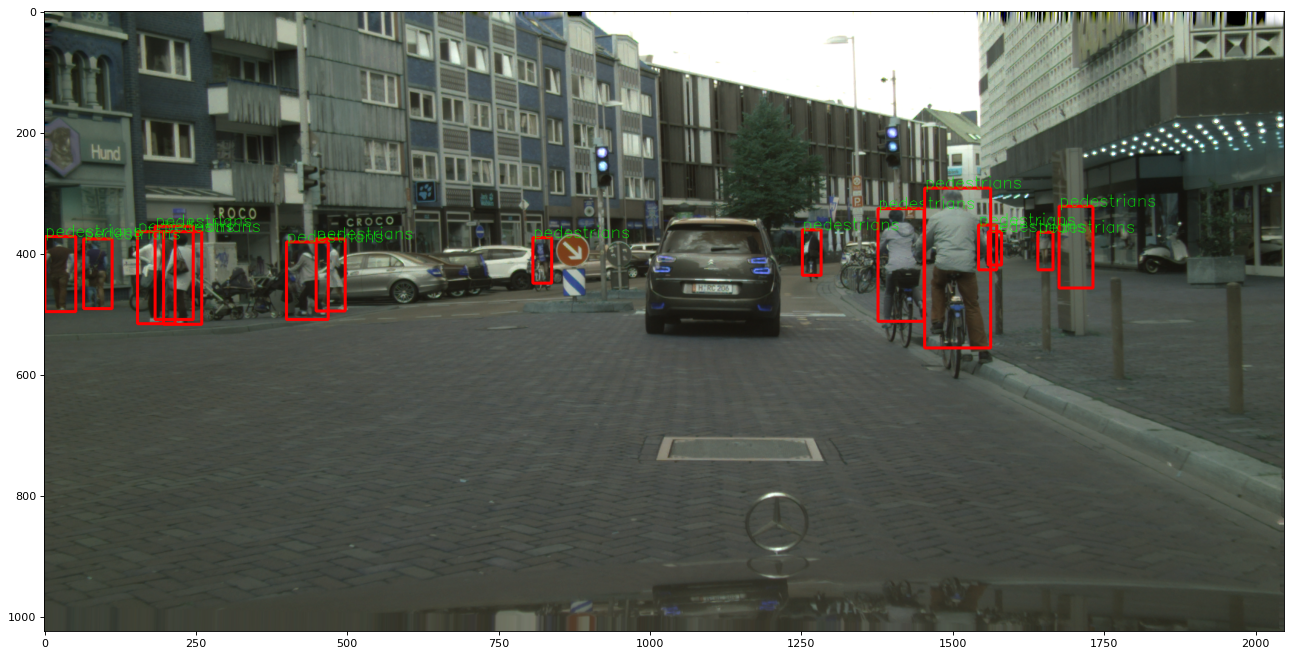

In [23]:
# example of displaying a picture with annotations
figure(figsize=(20, 16), dpi=80)
i=random.randint(0,2500)
all_ids=train_df['image_id'].unique()
c_box=train_df[train_df['image_id']==all_ids[i]][['class_label','x1','y1','w','h']].values
img_path='data/cityscapes/Cityscape/leftImg8bit/train/'+all_ids[i].split('_')[0]+'/'+all_ids[i]
img=cv2.imread(img_path)
print(img.shape)
plt.imshow(visual(img,c_box))

In [11]:
# make new directories for citypersons images and labels
os.makedirs('data/citypersons_dir/train/images')
os.makedirs('data/citypersons_dir/train/labels')
os.makedirs('data/citypersons_dir/valid/images')
os.makedirs('data/citypersons_dir/valid/labels')

In [12]:
# train_ids=list(train_df['image_id'].unique())
# val_ids=list(val_df['img_id'].unique())

# create a function to transfer informatoin from my download to the citypersons directory
def prepare_dir(from_dir,to_dir_img,to_dir_labels,df):
    id_list=list(df['image_id'].unique())
    for idd in tqdm(id_list):
        shutil.copy(from_dir+idd.split('_')[0]+'/'+idd, to_dir_img+idd)


    if to_dir_labels is not None:
        for idd in tqdm(id_list):
            types=df[df['image_id']==idd]['class_label'].values
            cords=df[df['image_id']==idd][['x1','y1','w','h']].values
            cords_new=np.zeros(cords.shape)
             
            cords_new[:,0]=(cords[:,0]+cords[:,2]/2)/2048
            cords_new[:,1]=(cords[:,1]+cords[:,3]/2)/1024
            cords_new[:,2]=cords[:,2]/2048
            cords_new[:,3]=cords[:,3]/1024


            all_cord_list=''
            for typ, cord in zip(types,cords_new):
                trial=[typ]+list(cord)
                prv=''
                for s in [str(x) for x in trial]:
                    prv=prv+' '+s

                all_cord_list=all_cord_list+prv+'\n'


            with open('{}{}.txt'.format(to_dir_labels,idd.split('.')[0]), 'w') as f:
                f.writelines(all_cord_list)

# move my training data images and labels into citypersons directory
from_dir='data/cityscapes/Cityscape/leftImg8bit/train/'
to_dir_img='data/citypersons_dir/train/images/'
to_dir_labels='data/citypersons_dir/train/labels/'
df=train_df
prepare_dir(from_dir,to_dir_img,to_dir_labels,df)

100%|██████████████████████████████████████| 2500/2500 [00:12<00:00, 205.69it/s]


In [13]:
# move my validation data images and labels into citypersons directory
from_dir='data/cityscapes/Cityscape/leftImg8bit/val/'
to_dir_img='data/citypersons_dir/valid/images/'
to_dir_labels='data/citypersons_dir/valid/labels/'
df=val_df
prepare_dir(from_dir,to_dir_img,to_dir_labels,df)

100%|████████████████████████████████████████| 441/441 [00:00<00:00, 588.08it/s]


NameError: name 'idd' is not defined

In [9]:
#### checking the annotations
idd=list(train_df['image_id'].unique())[random.randint(0,2000)]

image_BGR = cv2.imread('data/citypersons_dir/train/images/{}'.format(idd))

# Showing image shape
print('Image shape:', image_BGR.shape)  # tuple of (800, 1360, 3)

# Getting spatial dimension of input image
h, w = image_BGR.shape[:2]  # Slicing from tuple only first two elements

# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w))  # 800 1360

# Reading annotation txt file that has bounding boxes coordinates in YOLO format
with open('data/citypersons_dir/train/labels/{}'.format(idd.split('.')[0]+'.txt')) as f:
    # Preparing list for annotation of BB (bounding boxes)
    lst = []
    for line in f:
        lst += [line.rstrip()]
        print(line)

# Going through all BB
for i in range(len(lst)):
    # Getting current bounding box coordinates, its width and height
    bb_current = lst[i].split()
    x_center, y_center = int(float(bb_current[1]) * w), int(float(bb_current[2]) * h)
    box_width, box_height = int(float(bb_current[3]) * w), int(float(bb_current[4]) * h)
    
    # Now, from YOLO data format, we can get top left corner coordinates
    # that are x_min and y_min
    x_min = int(x_center - (box_width / 2))
    y_min = int(y_center - (box_height / 2))

    # Drawing bounding box on the original image
    cv2.rectangle(image_BGR, (x_min, y_min), (x_min + box_width, y_min + box_height), [172 , 10, 127], 2)

    # Preparing text with label and confidence for current bounding box
    class_current = 'Class: {}'.format(bb_current[0])

    # Putting text with label and confidence on the original image
    cv2.putText(image_BGR, class_current, (x_min, y_min - 5), cv2.FONT_HERSHEY_COMPLEX, 0.7, [172 , 10, 127], 2)

Image shape: (1024, 2048, 3)
Image height=1024 and width=2048
 1 0.632568359375 0.404296875 0.01025390625 0.048828125

 0 0.7080078125 0.42626953125 0.0166015625 0.0810546875

 0 0.4775390625 0.43017578125 0.0185546875 0.0908203125



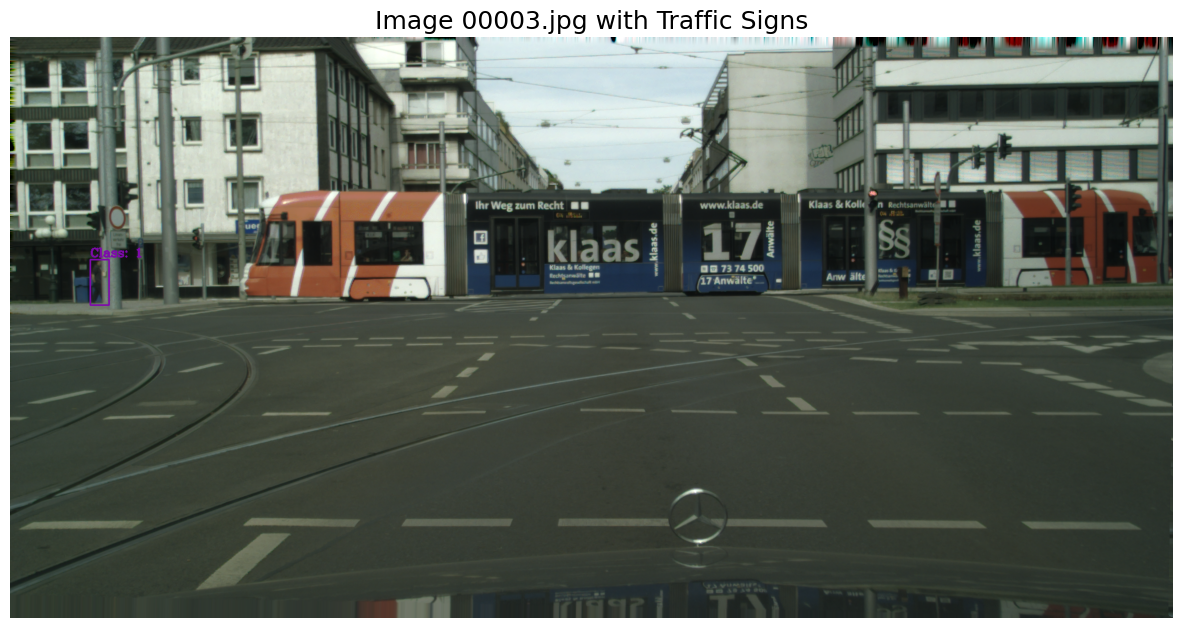

In [20]:
%matplotlib inline

# Plotting this example
# Setting default size of the plot
plt.rcParams['figure.figsize'] = (15, 15)

# Initializing the plot
fig = plt.figure()

plt.imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Image 00003.jpg with Traffic Signs', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('example.png')
plt.close()